# Import dependencies

In [32]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

import torch
from torch.utils.tensorboard import SummaryWriter

# Config Params

In [33]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
K_FOLDS = 3

# Our chosen datasets
TODO
We have chosen the datasets based on the following criteria:
- datasets where we do not need to do any special preprocessing so that it is easy to do in only one pipeline
- rather small datasets to ensure we do not need high computational power

In [34]:
# Dataset that seems useful
dataset_id = {"iris": 53, 
              "heart_disease": 45,
              "wine_quality": 186,
              "breast_cancer_wisconsin": 17,
              "car_evaluation": 19, # Not good maybe remove
              "abalone": 1,
              "mushroom": 73, # a lot of categorical data
              "statlog" : 144, # german credit
              "student_performance" : 320,
              "accute_inflammation" : 284,
              "credit_approval" : 143,
              "wholesale_customers" : 292,
              "glass_identifcation" : 42,
              "ilpd" : 225,
              "hcv" : 503,
              "land_mines" : 763,
              "balance_scale" : 12
              }


# Import and preprocess datasets
For the preprocessing we will do the following steps:
1. Remove any missing values. In the article the following is written: "Given that our classifiers are not oriented to data with missing features, the missing inputs are treated as zero, which should not bias the comparison results." We therefore also decided to just remove missing values and to more focus on the full pipeline instead of single datasets. Another way could have been interpolation.
2. Encode categorical data into numerical data. This we have to do to use the classifiers later on.
3. Remove certain columns if they are highly correlated to others.
4. Split the data into a train and a test set. We will use a 80/20 split.
5. Scale the data so that we have zero mean and standard deviation of one. This is done with the Standard scaler.

In [35]:
# function for converting categorical features into numerical
def encode_categorical_features(X, encoder):
    X = encoder.fit_transform(X)
    return X

In [36]:
def import_dataset(uci_id, encoder):
    # get the dataset
    dataset = fetch_ucirepo(id=uci_id) 
    # load data into dataframe for easier preprocessing
    df = pd.concat([dataset["data"]["features"],dataset["data"]["targets"] ],axis=1)
    # remove nan values
    df.dropna(inplace=True)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]
    # encode categorical data only for features not for target itself
    # https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
    cols = X.columns
    num_cols = X._get_numeric_data().columns
    #print(num_cols)
    categorical_cols = list(set(cols) - set(num_cols))
    #print(categorical_cols)
    X.loc[:, categorical_cols] = encode_categorical_features(X[categorical_cols], encoder)
    
    # check if encoding has worked
    # https://stackoverflow.com/questions/26924904/check-if-dataframe-column-is-categorical
    for c in X.columns:
        if X[c].dtype.name == "category":
            print(f"WARNING: Column {c} still has categorical values!")
            
    # last column is target
    return X, y

In [37]:
ordinal_encoder = OrdinalEncoder()
X, y = import_dataset(dataset_id["breast_cancer_wisconsin"], ordinal_encoder)
y = encode_categorical_features(y, ordinal_encoder)

In [38]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# K-means classifier


In [39]:
def kmeans_classification(X_train, y_train, X_test):
    # get the amount of clusters
    n_clusters = len(np.unique(y_train))
    # create k-means classifier
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)

    # normalize train data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    kmeans.fit(X_train)

    cluster_labels = kmeans.predict(X_train)
    labels_map = {}
    # loops through all cluster labels
    for cluster in np.unique(cluster_labels):
        class_label = mode(y_train[cluster_labels == cluster])[0] # selects the most common label for that cluster
        labels_map[cluster] = class_label # map that label to the cluster

    y_pred_train = np.array([labels_map[cluster] for cluster in cluster_labels]) # maps cluster to labels

    # normalize test data using train data mean and std
    X_test = scaler.transform(X_test)

    # predict and map for test set
    test_clusters = kmeans.predict(X_test)
    y_pred_test = np.array([labels_map[cluster] for cluster in test_clusters])

    return y_pred_train, y_pred_test

# For logging 

In [40]:
writer = SummaryWriter()

train_acc_dict = {}
train_f1_dict = {}
test_acc_dict = {}
test_f1_dict = {}

In [41]:
# Launch tensorboard
%tensorboard --logdir runs/ --port 6006
# If in use (Mac) use to find the process PID
% lsof -i :6006
# Kill the process with 
% kill -9 <PID>
# Then launch using bash with first command

UsageError: Line magic function `%tensorboard` not found.


# Testing different classifiers

In [42]:
def test_classifier(clf, clf_name, params, X_train, y_train, X_test, y_test):
    labels = np.unique(y_train)
    if clf_name == "kmeans":
        y_pred_train, y_pred_test = kmeans_classification(X_train, y_train, X_test)
    else:
        # https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
        pipe = Pipeline([('scaler', StandardScaler()), (clf_name, clf)])
        scoring = 'accuracy'
        gs_knn = GridSearchCV(pipe,
                            param_grid=params,
                            scoring=scoring,
                            cv=5)

        # Ravel to convert from (len, 1) shape to (len,), warning from sk-learn
        y_train = np.ravel(y_train)

        gs_knn.fit(X_train, y_train)
        print(gs_knn.best_params_)
        # find best model score
        y_pred_train = gs_knn.best_estimator_.predict(X_train)
        y_pred_test = gs_knn.best_estimator_.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    # TODO
    train_f1 = f1_score(y_train, y_pred_train, average="weighted")
    #train_score = gs_knn.score(X_train, y_train)

    # test on test set
    test_acc = accuracy_score(y_test, y_pred_test)
    # TODO
    test_f1 = f1_score(y_test, y_pred_test, average="weighted")
    #test_score = gs_knn.score(X_test, y_test)

    print(f"{clf_name}, Train accuracy = {train_acc}, Test accuracy = {test_acc}")
    print(f"{clf_name}, Train f1-score = {train_f1}, Test f1-score = {test_f1}")

    # Confusion Matrix
    print("Confusion Matrix for train set")
    cm_train = confusion_matrix(y_train, y_pred_train, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
    disp.plot()
    plt.show()

    print("Confusion Matrix for test set")
    cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
    disp.plot()
    plt.show()

    train_acc_dict[clf_name] = train_acc
    train_f1_dict[clf_name] = train_f1
    test_acc_dict[clf_name] = test_acc
    test_f1_dict[clf_name] = test_f1


# K-Nearest Neighbor classifier

{'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
knn, Train accuracy = 0.9802197802197802, Test accuracy = 0.9473684210526315
knn, Train f1-score = 0.9801024331803986, Test f1-score = 0.9473684210526315
Confusion Matrix for train set


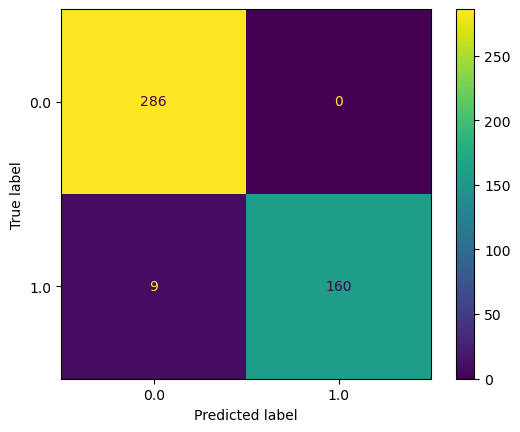

Confusion Matrix for test set


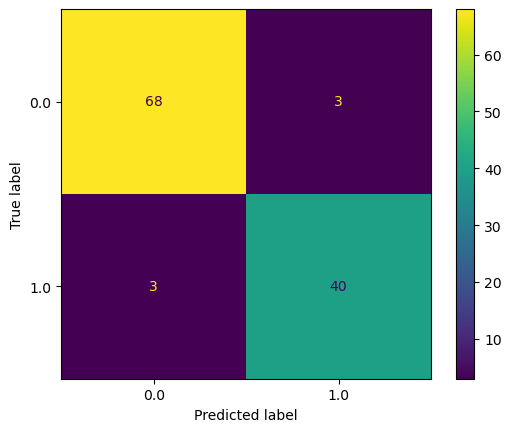

In [43]:
# https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
knn = KNeighborsClassifier()
params = [{'knn__n_neighbors': [3, 5, 7, 9],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [15, 20]}]

test_classifier(knn, "knn", params, X_train, y_train, X_test, y_test)


# SVM

{'svm__C': 1000, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
svm, Train accuracy = 0.9824175824175824, Test accuracy = 0.9736842105263158
svm, Train f1-score = 0.9823958851833416, Test f1-score = 0.973621425014614
Confusion Matrix for train set


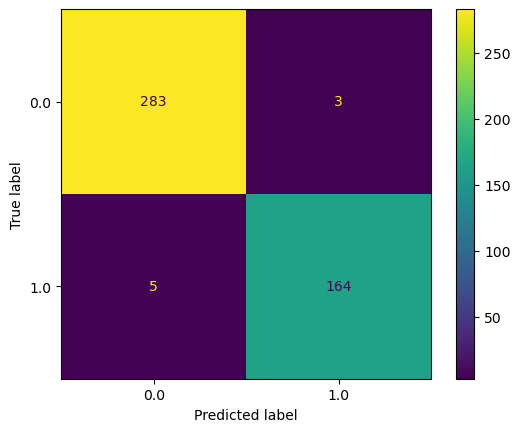

Confusion Matrix for test set


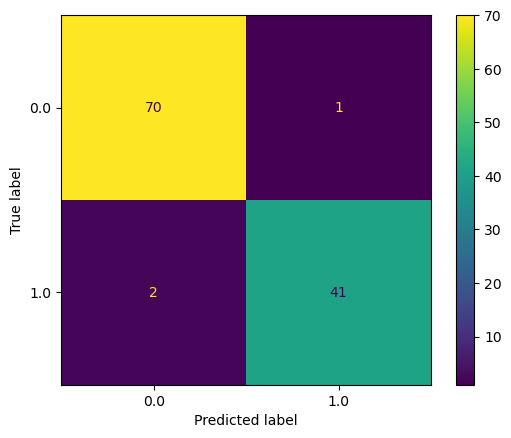

In [44]:
svm = SVC()
# params taken from here: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
params = [{'svm__C': [0.1, 1, 10, 100, 1000],  
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svm__kernel': ['rbf']} ]

test_classifier(svm, "svm", params, X_train, y_train, X_test, y_test)

# Linear Regression

/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

{'log_reg__C': np.float64(0.08858667904100823), 'log_reg__max_iter': 100, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
log_reg, Train accuracy = 0.9824175824175824, Test accuracy = 0.9912280701754386
log_reg, Train f1-score = 0.9823733485410132, Test f1-score = 0.991207141671538
Confusion Matrix for train set


/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5200 fits failed out of a total of 8000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emillundin/anaconda3/envs/D7041EMiniProject/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

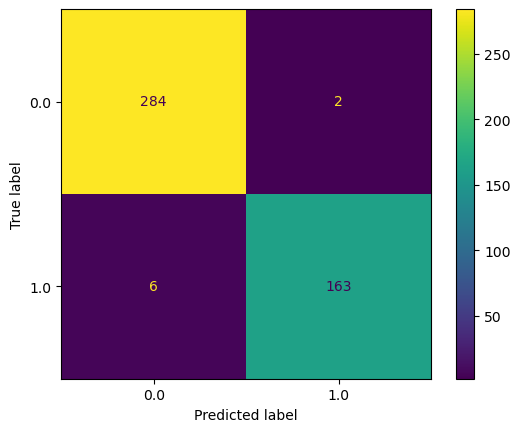

Confusion Matrix for test set


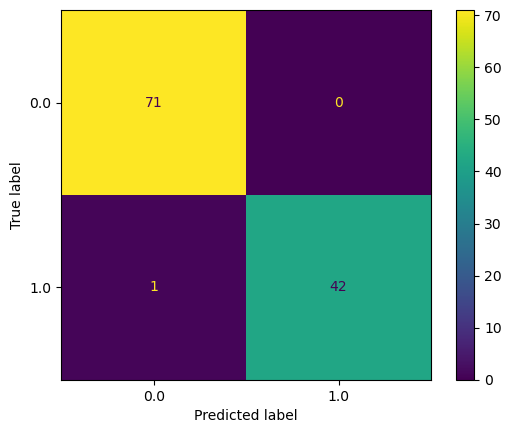

In [45]:
log_reg = LogisticRegression()
# params taken from here: https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/
params = [
    {'log_reg__penalty':['l1','l2','elasticnet','none'],
    'log_reg__C' : np.logspace(-4,4,20),
    'log_reg__solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'log_reg__max_iter'  : [100,1000,2500,5000]
}
]

test_classifier(log_reg, "log_reg", params, X_train, y_train, X_test, y_test)

# K-means clustering classification

kmeans, Train accuracy = 0.8967032967032967, Test accuracy = 0.9298245614035088
kmeans, Train f1-score = 0.8957851037851037, Test f1-score = 0.928615457562826
Confusion Matrix for train set


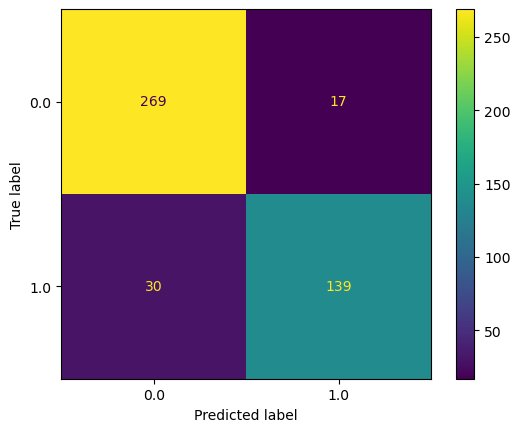

Confusion Matrix for test set


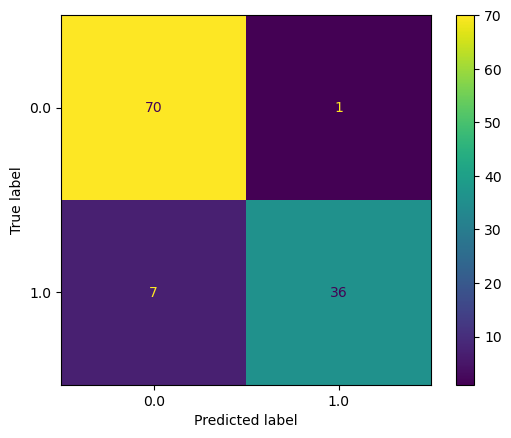

In [46]:
n_clusters = len(np.unique(y_train))
kmeans = KMeans(n_clusters = n_clusters, random_state=42)
params = [{"n_clusters": [n_clusters]}]

test_classifier(kmeans, "kmeans", params, X_train, y_train, X_test, y_test)

# Save logs

In [47]:
print(train_acc_dict)
print(test_acc_dict)
print(train_f1_dict)
print(test_f1_dict)

writer.add_scalars("Train acc", train_acc_dict)
writer.add_scalars("Test acc", test_acc_dict)
writer.add_scalars("Train f1", train_f1_dict)
writer.add_scalars("Test f1", test_f1_dict)
writer.close()